In [ ]:
import os
import re
import time
import pickle
import asyncio
import nest_asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import logging
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from typing import List, Dict, Any

from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.embeddings import ClovaXEmbeddings
from langchain_community.chat_models import ChatClovaX
from pymilvus import connections, utility
from langchain_community.vectorstores.milvus import Milvus
from langchain.schema import BaseRetriever
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel, Field

In [3]:
# 로깅 설정
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

##### Custom Retriever

In [ ]:
# ISBNMergingRetriever 클래스 (리팩토링 - ISBN 청크 병합 활용)
class ISBNMergingRetriever(BaseRetriever):
    base_retriever: BaseRetriever

    def _get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.base_retriever.get_relevant_documents(query)
        grouped, merged_docs = {}, []
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            if isbn == "NO_ISBN":
                # ISBN 없는 문서는 그대로 유지하거나, 필터링할 수 있음 (여기서는 유지 안 함)
                continue
            grouped.setdefault(isbn, []).append(doc)
        for isbn, doc_list in grouped.items():
            # 동일 ISBN 문서 병합
            combined_text = "\n".join(d.page_content for d in doc_list)
            # 메타데이터는 첫 번째 문서 것을 사용 (다 동일함)
            merged_meta = dict(doc_list[0].metadata)
            # 로깅
            logger.debug(
                f"[ISBN Merging] ISBN: {isbn}, Merged Chunks: {len(doc_list)}, Combined Text Length: {len(combined_text)}"
            )
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )

        logger.info(
            f"ISBN 기준으로 {len(grouped)} 그룹 병합 완료. 최종 문서 수: {len(merged_docs)}"
        )
        return merged_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:

        # 비동기 버전 - 로직은 동일
        docs = await self.base_retriever.aget_relevant_documents(query)
        grouped, merged_docs = {}, []
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            if isbn == "NO_ISBN":
                continue
            grouped.setdefault(isbn, []).append(doc)
        for isbn, doc_list in grouped.items():
            combined_text = "\n".join(d.page_content for d in doc_list)
            merged_meta = dict(doc_list[0].metadata)
            logger.debug(
                f"[Async ISBN Merging] ISBN: {isbn}, Merged Chunks: {len(doc_list)}, Combined Text Length: {len(combined_text)}"
            )
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )
        logger.info(
            f"Async ISBN 기준으로 {len(grouped)} 그룹 병합 완료. 최종 문서 수: {len(merged_docs)}"
        )
        return merged_docs

    def add_documents(self, documents: List[Document], **kwargs) -> None:
        # 이 리트리버는 문서를 직접 추가하는 기능은 없음 (Base Retriever가 함)
        pass

    def get_type(self) -> str:  # Pydantic 버전 호환성
        return "isbn_merging_retriever"

In [5]:
# text는 아래와 같은 형태로 들어가서 청크

# 제목 : [값]
# 분류 : [값]
# 저자 : [값]
# 저자소개 : [값]
# 책 소개 : [값]
# 목차 : [값]
# 출판사리뷰 : [값]

# 임베딩 pkl에 포함된 메타데이터 컬럼과 (임베딩,원본text)로 묶인 컬럼

# metadata_columns = ['ISBN', '페이지', '가격', '제목', '저자']
# vector_doc_columns = ['제목', '분류', '저자','저자소개', '책소개', '목차', '출판사리뷰','추천사']

##### Util Function

In [ ]:
def is_similar_question(new_emb, prev_embeds, threshold=0.65):
    if not prev_embeds:
        return False
    sim_scores = cosine_similarity([new_emb], prev_embeds)[0]
    max_score = max(sim_scores)
    logger.info(f"[중복 유사도 판단] Max = {max_score:.3f}")
    return max_score > threshold


def extract_field(text, field_name):
    # 필드 이름 뒤 공백 허용, 값 시작 부분의 공백 제거
    pattern = rf"^\s*{re.escape(field_name)}\s*:\s*(.*?)\s*$"
    lines = text.splitlines()
    for line in lines:
        match = re.search(pattern, line, re.IGNORECASE)  # 대소문자 무시
        if match:
            return match.group(1).strip()
    return ""  # 매칭되는 필드가 없으면 빈 문자열 반환하도록

##### 환경설정 & 임베딩

In [ ]:
load_dotenv(dotenv_path=r"C:\Kill_the_RAG\Project\Aiffel_final_project\.env")

# API 키 & 환경 변수 설정
api_key = os.getenv("NCP_CLOVASTUDIO_API_KEY")
api_url = os.getenv("NCP_CLOVASTUDIO_API_URL", "https://clovastudio.stream.ntruss.com/")
milvus_host = os.getenv("MILVUS_HOST", "localhost")
milvus_port = os.getenv("MILVUS_PORT", "19530")

if not api_key:
    raise ValueError("NCP_CLOVASTUDIO_API_KEY 환경 변수가 설정되지 않았습니다.")
if not api_url:
    raise ValueError("NCP_CLOVASTUDIO_API_URL 환경 변수가 설정되지 않았습니다.")

os.environ["NCP_CLOVASTUDIO_API_KEY"] = api_key
os.environ["NCP_CLOVASTUDIO_API_URL"] = api_url

logger.info(
    "Milvus 전역 연결 설정 건너뛰고, Langchain Milvus 인스턴스가 직접 관리하도록 설정합니다."
)

# 모델 초기화
try:
    ncp_embeddings = ClovaXEmbeddings(model="bge-m3")
    llm_clova = ChatClovaX(model="HCX-003", max_tokens=2048)
    logger.info("ClovaX Embeddings 및 Chat 모델 초기화 완료")
except Exception as e:
    logger.error(f"ClovaX 모델 초기화 실패: {e}")
    raise

# 임베딩 pkl 로드

embedding_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"
if os.path.exists(embedding_file):
    try:
        with open(embedding_file, "rb") as f:
            saved_data = pickle.load(f)
        all_text_embedding_pairs = saved_data[
            "embeddings"
        ]  # (text, embedding) 튜플 쌍 list
        all_metadata_list = saved_data["metadata"]  # 메타데이터 딕셔너리 list
        logger.info(f"임베딩 데이터 로드 완료: {len(all_text_embedding_pairs)}개")
    except Exception as e:
        logger.error(f"임베딩 파일 로드 실패: {e}")
        raise
else:
    raise FileNotFoundError(f"임베딩 파일을 찾을 수 없습니다: {embedding_file}")

# 메타데이터 매핑
metadata_mapping = {
    "ISBN": "ISBN",
    "페이지": "page",
    "가격": "price",
    "제목": "title",
    "저자": "author",
    "분류": "category",
    "저자소개": "author_intro",
    "책소개": "book_intro",
    "목차": "table_of_contents",
    "출판사리뷰": "publisher_review",
    "추천사": "recommendation",
}


# Document 생성

documents = []

for pair, meta in zip(all_text_embedding_pairs, all_metadata_list):
    # pair[0]: text
    # pair[1]: embedding
    # meta: original metadata dict
    standardized_meta = {metadata_mapping.get(k, k): v for k, v in meta.items()}
    # Document에 메타데이터 포함
    documents.append(Document(page_content=pair[0], metadata=standardized_meta))

logger.info(f"총 {len(documents)}개의 Document 객체 생성 완료.")

# Milvus 컬렉션 설정 및 데이터 추가
collection_name = "book_rag_db"
temp_conn_alias = "utility_check_conn"  # 충돌방지
try:
    # 유틸리티 함수 사용 전에 임시로 연결 설정
    connections.connect(alias=temp_conn_alias, host=milvus_host, port=milvus_port)
    logger.info(
        f"Milvus 유틸리티 함수용 임시 연결 설정 완료 (alias: {temp_conn_alias})."
    )

    # utility 함수 호출 시 'using' 파라미터로 해당 alias 지정
    if utility.has_collection(collection_name, using=temp_conn_alias):
        logger.warning(
            f"기존 컬렉션 '{collection_name}'을 삭제합니다 (using: {temp_conn_alias})."
        )
        utility.drop_collection(collection_name, using=temp_conn_alias)
    else:
        logger.info(f"컬렉션 '{collection_name}'이(가) 존재하지 않습니다.")

except Exception as e:
    logger.error(f"Milvus 유틸리티 함수 실행 중 오류 발생: {e}", exc_info=True)

    try:
        connections.disconnect(temp_conn_alias)
        logger.info(f"오류 발생 후 Milvus 임시 연결 해제됨 (alias: {temp_conn_alias}).")
    except Exception as disconnect_e:
        logger.error(f"Milvus 임시 연결 해제 중 오류: {disconnect_e}")
    raise
finally:
    # 정상 실행 시에도 연결 해제 (finally 블록에서 확실히 해제)
    try:
        if connections.has_connection(
            temp_conn_alias
        ):  # 연결이 실제로 있는지 확인 후 해제
            connections.disconnect(temp_conn_alias)
            logger.info(
                f"Milvus 유틸리티 함수용 임시 연결 해제 완료 (alias: {temp_conn_alias})."
            )
    except Exception as disconnect_e:
        # 연결 설정 자체가 실패했을 수 있으므로 해제 오류는 경고로 처리 가능
        logger.warning(f"Milvus 임시 연결 해제 중 오류 (무시 가능): {disconnect_e}")

try:
    vectorstore = Milvus(
        embedding_function=ncp_embeddings,
        collection_name=collection_name,
        connection_args={"host": milvus_host, "port": milvus_port},
        auto_id=True,
    )
    logger.info(
        f"Langchain Milvus 인스턴스 초기화 및 연결 설정 완료 (컬렉션: '{collection_name}')."
    )

    # 불러온 임베딩
    texts = [doc.page_content for doc in documents]
    embeds = [pair[1] for pair in all_text_embedding_pairs]
    metadatas = [doc.metadata for doc in documents]

    # 상솓ㄱ
    original_embed_documents = ClovaXEmbeddings.embed_documents

    def precomputed_embed_documents(cls, input_texts):
        # 매핑 순서 일치 확인
        if len(input_texts) != len(texts) or input_texts != texts:
            logger.warning(
                "입력 텍스트가 사전 계산된 텍스트와 다릅니다. 순서/내용 확인 필요."
            )
        return embeds

    ClovaXEmbeddings.embed_documents = classmethod(precomputed_embed_documents)

    vectorstore.add_texts(
        texts=texts, metadatas=metadatas, embeddings=embeds
    )  # embeddings 밀버스 전달
    logger.info(f"Milvus에 {len(texts)}개의 텍스트와 임베딩 추가 완료.")

    ClovaXEmbeddings.embed_documents = original_embed_documents

except Exception as e:
    logger.error(f"Milvus 데이터 추가 중 오류 발생: {e}")
    if "original_embed_documents" in locals():
        ClovaXEmbeddings.embed_documents = original_embed_documents
    raise

2025-04-04 13:20:36,541 - INFO - Milvus 전역 연결 설정 건너뛰고, Langchain Milvus 인스턴스가 직접 관리하도록 설정합니다.
2025-04-04 13:20:37,507 - INFO - ClovaX Embeddings 및 Chat 모델 초기화 완료
2025-04-04 13:20:46,509 - INFO - 임베딩 데이터 로드 완료: 99845개
2025-04-04 13:20:48,395 - INFO - 총 99845개의 Document 객체 생성 완료.
2025-04-04 13:20:48,644 - INFO - Milvus 유틸리티 함수용 임시 연결 설정 완료 (alias: utility_check_conn).
2025-04-04 13:20:48,652 - WARNING - 기존 컬렉션 'book_rag_db'을 삭제합니다 (using: utility_check_conn).
2025-04-04 13:20:48,766 - INFO - Milvus 유틸리티 함수용 임시 연결 해제 완료 (alias: utility_check_conn).
C:\Users\computer\AppData\Local\Temp\ipykernel_19504\3339307333.py:129: LangChainDeprecationWarning: The class `Milvus` was deprecated in LangChain 0.2.0 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-milvus package and should be used instead. To use it run `pip install -U :class:`~langchain-milvus` and import as `from :class:`~langchain_milvus import MilvusVectorStore``.
  vectorstore = Milvus(
202

#####  Retriever 및 QA 체인

In [ ]:
# 기본 Dense Retriever 설정 (Vector Store)
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})  # 5+5

# ISBN 기준으로 병합하는 Retriever 한개 더 감싸서 설정
merged_retriever = ISBNMergingRetriever(base_retriever=dense_retriever)

# RetrievalQA 체인 설정 (병합된 Retriever)
dpr_qa_chain = RetrievalQA.from_chain_type(
    llm=llm_clova,
    retriever=merged_retriever,
    return_source_documents=True,  # 소스 문서 반환 활성화
)

MIN_INFO_LENGTH = 10  # 정보 길이 최소값 - 이것보다 짧으면 추천 이유 생성 못함함

# 전역 변수 생성
previous_additional_question_embeddings = []

##### Prompt

In [ ]:
# 1. 사용자 선호도 추출 프롬프트
extract_pref_prompt_v2 = PromptTemplate(
    input_variables=["text"],
    template="""
다음 사용자 발화에서 사용자의 선호도 및 책에 대한 요구사항을 아래 JSON 형식으로 추출해라. 각 항목은 관련된 정보가 명확할때만 포함하고, 없다면 빈 리스트 `[]` 또는 빈 문자열 `""`로 남겨라. 여러개가 추출될 수 있는 항목은 리스트로 추출하라.

입력: {{ text }}

출력 형식 (JSON, 다른 설명 없이 JSON만 출력):
{
    "title": [<!-- 추출된 책 제목 -->],
    "author": [<!-- 추출된 책 저자 -->],
    "category": [<!-- 추출된 책 카테고리/장르 -->],
    "author_intro": [<!-- 저자 특성 언급/요구사항 -->],
    "book_intro": [<!-- 줄거리 관련 언급/요구사항 -->],
    "table_of_contents": [<!-- 세부적인 키워드 언급/요구사항 -->],
    "purpose": [<!-- 사용자의 독서 목적/이유 목록 (예: '재미', '학습', '시간 때우기', '기분') -->],
    "implicit info": [<!-- 추천해야 할 책에 대한 암시적 정보/특징/분위기 목록 (예: '밝은 분위기', '특정 상황에 어울리는 책', '최신 기술 동향') -->]
}
""",
    template_format="jinja2",  # 변수 치환을 위한 탬플릿
)

# 2. 선호도 통합 프롬프트
consolidate_pref_prompt = PromptTemplate(
    input_variables=["existing_preferences", "new_preferences"],
    template="""
기존에 수집된 사용자 선호도 정보와 새로 추출된 선호도 정보가 주어졌다. 두 정보를 지능적으로 통합하여 중복을 제거하고 관련 내용을 요약/결합하여 최종 선호도 목록을 생성해라.

[기존 선호도]
{{ existing_preferences }}

[새로운 선호도]
{{ new_preferences }}

[통합된 최종 선호도 목록]
(아래 목록 형태로만 출력, 각 항목은 문자열 리스트)
- 항목1: ["통합 내용1", "통합 내용2"]
- 항목2: ["통합 내용3"]
...
""",
    template_format="jinja2",
)

# 3. Decision Prompt
decision_prompt_template = PromptTemplate(
    template="""
[대화 맥락]
사용자 대화 내역:
{{ history }}
사용자의 최신 질문: "{{ query }}"
수집된 사용자 선호도:
{{ preferences }}

[역할 및 목표]
{{ role_instructions }}
현재 대화 상황, 질문, 수집된 선호도를 분석하여 아래 두 가지 행동 중 하나만 결정하고 필요한 정보를 생성하라.
- "추천": 사용자가 명시적으로 추천을 요청했거나, 사용자의 선호도 정보(카테고리, 저자, 목적, 분위기 등)를 반드시 3개 이상 수집했을 때만 추천에 들어가라.
- "추가 질문": 추천하기에 정보가 부족하거나 모호할 때, **아직 수집되지 않았거나 더욱 구체적인 선호도 정보**를 얻기 위한 질문 생성. (예: 어떤 장르를 선호하시나요? 특정 작가를 찾으시나요? 책을 읽는 목적이 무엇인가요?)

[출력 형식] (반드시 아래 형식만 정확히 따를 것)
행동: <추천 또는 추가 질문>
추가 질문: <"추가 질문" 행동일 경우 구체적인 질문 생성, "추천" 행동일 경우 빈 문자열>
""",
    input_variables=["history", "query", "preferences", "role_instructions"],
    template_format="jinja2",
)

# 4. Final Query Generation Prompt
final_query_generation_template = PromptTemplate(
    template="""
[대화 요약]
{{ history }}

[사용자 요청]
{{ query }}

[페르소나 정보]
{{ persona_info }}

[사용자 선호도 요약]
{{ preferences }}

위 정보를 전부 활용하여, 도서 검색에 가장 유용한 **핵심 키워드 중심의 최종 검색 쿼리**를 한 문장으로 작성하라.
오직 검색 쿼리 문장만 출력하라.
""",
    input_variables=["history", "query", "persona_info", "preferences"],
    template_format="jinja2",
)

# 5. Refine Prompt - 추후 더 업데이트를 통해 정제 기능 활성화
refine_prompt = PromptTemplate(
    input_variables=["query"],
    template="""주어진 검색 쿼리를 분석하여, 검색 엔진이나 다음 단계에서 사용하기 좋은 명확하고 간결한 단일 문장으로 정제해라. 불필요한 설명 없이 오직 정제된 쿼리 문장만 출력해라.

- "~~비슷한", "~ 같은", "~ 분위기의" 라고 사용자가 언급하면, 해당 책/저자의 **특징(예: 장르, 분위기, 핵심 소재, 작가 스타일)**을 반영하여 확장하라. 책 제목이나 저자 이름은 절대 직접 포함하지 마라.
- 예시 (입력: 해리포터 시리즈물같은 판타지 소설 알려줘) ->
1. 마법학교 배경의 청소년 판타지 소설 추천
2. 선과 악의 대결을 다룬 영국 판타지 시리즈
3. 성장 서사를 담은 인기 판타지 소설

[원본 검색 쿼리]
{{ query }}

[정제된 검색 쿼리]
""",
    template_format="jinja2",
)

# 6. Query Expansion Prompt
query_expansion_prompt = PromptTemplate(
    input_variables=["query"],
    template="""주어진 원본 검색 쿼리를 바탕으로, 관련성이 높으면서도 다양한 측면을 탐색할 수 있는 확장된 검색 쿼리 3개를 생성해라. 확장된 쿼리는 원본 쿼리의 핵심 의도를 반드시 유지해야 한다. 다른 설명이나 서론 없이, 오직 번호(1., 2., 3.)가 매겨진 확장 쿼리 목록만 한 줄에 하나씩 출력해라.

[원본 검색 쿼리]
{{ query }}

[확장된 검색 쿼리 목록]
""",
    template_format="jinja2",
)

# 7. Re_ranking Prompt
re_ranking_prompt = PromptTemplate(
    input_variables=["query", "documents"],
    template="""사용자의 검색 쿼리는 다음과 같습니다: "{{ query }}"
다음은 검색된 도서 목록입니다 (내용은 일부만 표시됨):
{% for doc in documents %}
{{ loop.index }}. 제목: {{ doc.metadata.get('title', '제목 없음') }}, 저자: {{ doc.metadata.get('author', '저자 없음') }}, 내용 일부: {{ doc.page_content | truncate(200) }}
{% endfor %}

위 검색 결과를 사용자의 검색 쿼리 "{{ query }}"와의 관련성, 그리고 문서 내용의 충실도를 종합적으로 고려하여 가장 적합한 순서대로 재배치하라.
가장 관련성이 높은 도서를 목록의 맨 위에 배치하고, 순위가 매겨진 **도서 제목과 저자**만으로 결과를 다음 형식으로 출력하라.

[출력 형식 예시]
1. 제목: <가장 관련성 높은 책 제목>, 저자: <저자 이름>
2. 제목: <두 번째 관련성 높은 책 제목>, 저자: <저자 이름>
...

[리랭킹된 도서 목록]
""",
    template_format="jinja2",
)

# 8. HyDE Generation Prompt
hyde_generation_prompt = PromptTemplate(
    input_variables=["query"],
    template="""다음 검색 쿼리에 완벽하게 부합하는 **이상적인 가상의 책**에 대한 **간결한 요약(1-2 문장)**을 생성해라. 이 요약은 해당 쿼리로 책을 찾는 사용자가 가장 만족할 만한 내용을 담고 있어야 한다. 오직 생성된 요약 텍스트만 출력하라.

[검색 쿼리]
{{ query }}

[가상의 책 요약]
""",
    template_format="jinja2",
)

# 9. Persona prompt
literature_role = "너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 깊이 이해하고 공감하며, 문학적인 표현을 사용하여 책을 추천해라."
science_role = "너는 정확하고 논리적인 과학/기술 도서 추천 챗봇이다. 사용자의 지식 수준과 관심 분야를 파악하고, 최신 정보와 기술 동향을 반영하여 체계적으로 책을 추천해라."
general_role = "너는 친절하고 신뢰할 수 있는 범용 도서 추천 챗봇이다. 다양한 분야의 책에 대해 균형 잡힌 시각으로 정보를 제공하고, 사용자의 요구사항에 맞춰 명확하고 이해하기 쉽게 책을 추천해라."

##### Async Invoke function

In [ ]:
async def async_invoke(chain: LLMChain, vars_dict: dict, step_name: str) -> dict:
    """LLMChain을 비동기적으로 호출하고 결과 반환"""
    try:
        logger.debug(
            f"[{step_name}] Chain 호출 시작. 입력 변수 일부: { {k: v[:100] + '...' if isinstance(v, str) and len(v) > 100 else v for k, v in vars_dict.items()} }"
        )
        # asyncio.to_thread 사용으로 동기 함수를 비동기 이벤트 루프에서 실행되도록
        result = await asyncio.to_thread(chain.invoke, vars_dict)
        result_text = result.get("text", "")
        logger.debug(
            f"[{step_name}] Chain 호출 완료. 결과 일부: {result_text[:200] + '...' if len(result_text) > 200 else result_text}"
        )
        return result
    except Exception as e:
        logger.error(f"[{step_name}] Chain 호출 중 예외 발생: {e}", exc_info=True)
        return {"text": ""}


async def async_invoke_llm(prompt: str, step_name: str) -> str:
    """LLM을 직접 비동기적으로 호출하고 결과 반환"""
    try:
        logger.debug(
            f"[{step_name}] LLM 호출 시작. 프롬프트 일부: {prompt[:200] + '...' if len(prompt) > 200 else prompt}"
        )
        response = await asyncio.to_thread(llm_clova.invoke, prompt)

        if hasattr(response, "content"):
            result_text = response.content.strip()
        elif hasattr(response, "text"):
            result_text = response.text().strip()
        else:
            result_text = str(response).strip()

        logger.debug(
            f"[{step_name}] LLM 호출 완료. 응답 일부: {result_text[:200] + '...' if len(result_text) > 200 else result_text}"
        )
        return result_text
    except Exception as e:
        logger.error(f"[{step_name}] LLM 호출 중 예외 발생: {e}", exc_info=True)
        return ""

##### Weighting Fucntion - 추후 페르소나별로 다르게 적용할 수 있다면?

In [ ]:
def weighted_sort(
    docs: List[Document], preferences: Dict[str, List[str]]
) -> List[Document]:
    """집중해야할 field 별로 or 선호도 별로 청크 리랭킹 점수에에"""

    def score(doc):
        s = 0.0
        author_pref = preferences.get("author", [])

        if author_pref and doc.metadata.get("author") in author_pref:
            s += 0.3  # 저자 일치 시
        category_pref = preferences.get("category", [])
        if category_pref and doc.metadata.get("category") in category_pref:
            s += 0.2  # 카테고리 일치 시

        # implicit info의 점수화
        implicit_pref = preferences.get("implicit info", [])
        if implicit_pref:
            content_lower = doc.page_content.lower()
            for keyword in implicit_pref:
                if keyword.lower() in content_lower:
                    s += 0.1  # 암시적 정보 키워드 포함 시 약간의 가중치
        return s

    # 점수가 높은 순으로 정렬, 점수가 같으면 원래 순서 유지
    return sorted(docs, key=score, reverse=True)

##### Base RAG Pipeline

In [ ]:
class BaseRAGPipeline:
    def __init__(
        self, config, llm, embeddings, vectorstore, retriever, qa_chain, documents
    ):
        self.config = config
        self.llm = llm
        self.embeddings = embeddings  # 임베딩 모델 추가
        self.vectorstore = vectorstore  # Vectorstore 직접 접근 위해 추가
        self.retriever = retriever  # ISBN Merging Retriever
        self.qa_chain = qa_chain  # 기본 QA 체인 (사용 빈도 줄어들 수 있음)
        self.documents = documents  # 전체 문서 목록 (메타데이터 접근용)

        # 대화 기록 및 상태 변수
        self.user_history: List[str] = []
        self.llm_history: List[str] = []
        # 사용자 선호도 구조 변경 (JSON)
        self.user_preferences: Dict[str, List[str]] = {
            "title": [],
            "author": [],
            "category": [],
            "author_intro": [],
            "book_intro": [],
            "table_of_contents": [],
            "purpose": [],
            "implicit info": [],
        }
        self.preferences_text: str = ""  # 선호도 요약 텍스트
        self.preference_update_count: int = 0

        self.last_recommendations: List[Document] = []
        self.last_action: str | None = None  # 마지막 챗봇 행동 (추천 or 추가 질문)

        # LLM Chain 초기화
        self.extract_pref_chain = LLMChain(llm=self.llm, prompt=extract_pref_prompt_v2)
        # self.consolidate_pref_chain = LLMChain(llm=self.llm, prompt=consolidate_pref_prompt) # LLM 통합은 일단 보류
        self.decision_chain = LLMChain(llm=self.llm, prompt=decision_prompt_template)
        self.final_query_generation_chain = LLMChain(
            llm=self.llm, prompt=final_query_generation_template
        )
        self.refine_chain = LLMChain(
            llm=self.llm, prompt=refine_prompt
        )  # refine chain 추가
        self.query_expansion_chain = LLMChain(
            llm=self.llm, prompt=query_expansion_prompt
        )
        self.re_ranking_chain = LLMChain(llm=self.llm, prompt=re_ranking_prompt)
        self.hyde_generation_chain = LLMChain(
            llm=self.llm, prompt=hyde_generation_prompt
        )

    def robust_parse_decision_response(
        self, response_text: str
    ) -> tuple[str | None, str]:
        """LLM의 행동 결정 응답을 파싱"""
        action_match = re.search(r'행동\s*[:：]\s*"?([^"\n]+)"?', response_text)
        action = action_match.group(1).strip() if action_match else None

        follow_match = re.search(r'추가\s*질문\s*[:：]\s*"?([^"\n]+)"?', response_text)
        additional_question = follow_match.group(1).strip() if follow_match else ""

        if not action:
            logger.warning(
                f"행동 결정 파싱 실패: '{response_text}'. 기본 '추가 질문'으로 처리."
            )
            # 파싱 실패 시 안전하게 추가 질문 유도가 맞을듯
            return "추가 질문", additional_question

        logger.info(
            f"행동 결정 파싱 결과: 행동='{action}', 추가 질문='{additional_question}'"
        )
        return action, additional_question

    async def update_preferences_from_input(self, user_input: str) -> None:
        """
        사용자 입력에서 선호도를 추출하고 기존 선호도와 통합합니다.
        """
        logger.info(f"사용자 입력에서 선호도 추출 시작: '{user_input[:100]}...'")

        # 1. LLM을 사용하여 선호도 추출
        extract_result = await async_invoke(
            self.extract_pref_chain, {"text": user_input}, "선호도 추출"
        )
        extracted_text = extract_result.get("text", "{}")

        try:
            # LLM 응답에서 JSON 부분만 추출
            json_match = re.search(r"\{.*\}", extracted_text, re.DOTALL)
            if json_match:
                extracted_prefs_raw = json.loads(json_match.group(0))
            else:
                logger.warning(
                    f"선호도 추출 결과에서 JSON 객체를 찾을 수 없음: {extracted_text}"
                )
                extracted_prefs_raw = {}

            # 값들이 리스트 형태인지 확인 및 변환, 정의된 키만 사용
            extracted_prefs: Dict[str, List[str]] = {}
            defined_keys = self.user_preferences.keys()
            for key, value in extracted_prefs_raw.items():
                if key in defined_keys:
                    if isinstance(value, list):
                        extracted_prefs[key] = [
                            str(item) for item in value if item
                        ]  # 빈 항목 제거 및 문자열화
                    elif isinstance(value, str) and value:
                        extracted_prefs[key] = [value]
                    # 다른 타입(숫자 등)이 올 경우 문자열로 변환하여 리스트에 추가할 수도 있음
                    else:  # None 이거나 빈 값은 무시
                        pass

                else:
                    logger.warning(
                        f"추출된 선호도 키 '{key}'가 정의된 형식에 없음. 무시."
                    )

            logger.info(
                f"추출 및 정제된 선호도: {json.dumps(extracted_prefs, ensure_ascii=False)}"
            )

        except json.JSONDecodeError as e:
            logger.error(
                f"선호도 추출 결과 JSON 파싱 실패: {e}. 원본 텍스트: {extracted_text}"
            )
            extracted_prefs = {}  # 파싱 실패 시 빈 객체로

        if not extracted_prefs:
            logger.info("새로 추출된 유효한 선호도 정보가 없음")
        else:
            # 2. 기존 선호도 통합
            updated_something = False
            for key, new_values in extracted_prefs.items():
                if new_values:  # 새로운 값이 있을 때만
                    existing_values_set = set(self.user_preferences.get(key, []))
                    new_values_set = set(new_values)
                    # 기존값은 유지한채로 새로운 값 추가
                    added_values = new_values_set - existing_values_set
                    if added_values:
                        self.user_preferences[key].extend(list(added_values))
                        self.user_preferences[key] = sorted(
                            list(set(self.user_preferences[key]))
                        )  # 최종 정렬 & 중복제거
                        updated_something = True
                        logger.info(
                            f"선호도 업데이트됨 [{key}]: {self.user_preferences[key]}"
                        )

            if updated_something:
                self.preference_update_count += 1
                logger.info(
                    f"선호도 업데이트 완료. 누적 업데이트 횟수: {self.preference_update_count}"
                )
            else:
                logger.info("기존 선호도에서 변경된 내용 없음.")

        # 3. 선호도 요약 텍스트 업데이트 (LLM 입력용)
        pref_items = []
        for key, values in self.user_preferences.items():
            if values:  # None이면 건너뜀
                # 키 이름을 좀 더 자연스러운 한국어로 변경 (선택 사항)
                display_key = {
                    "title": "관련 제목",
                    "author": "관련 저자",
                    "category": "선호 장르/분류",
                    "author_intro": "저자 관련 요구",
                    "book_intro": "내용 관련 요구",
                    "table_of_contents": "목차 관련 요구",
                    "purpose": "독서 목적",
                    "implicit info": "책에 대한 암시적 요구",
                }.get(key, key)
                pref_items.append(f"- {display_key}: {', '.join(values)}")
        self.preferences_text = (
            "\n".join(pref_items) if pref_items else "수집된 선호도 없음"
        )
        logger.debug(f"업데이트된 선호도 요약 텍스트:\n{self.preferences_text}")

    async def get_final_query(self, current_user_query: str) -> str:
        """
        대화 기록, 사용자 쿼리, 페르소나 정보, 통합된 선호도를 바탕으로 최종 검색 쿼리를 생성하고 정제.
        """
        logger.info("최종 검색 쿼리 생성 시작")

        # 페르소나 정보
        persona = self.config.get("persona")
        if persona == "Literature":
            persona_info = "감성, 현재 기분, 선호하는 문학 장르 및 작가 정보"
        elif persona == "Science":
            persona_info = "초심자 여부, 관심 분야, 구체적인 기술 정보"
        else:  # General 또는 기타
            persona_info = "장르, 책을 찾는 이유, 독서 취향 정보"

        # LLM에 전달할 변수 준비 - 이걸로 1차 query를 생성함
        final_query_vars = {
            "history": "\n".join(self.user_history[-5:]),  # 최근 5개 대화 이력
            "query": current_user_query,  # 가장 현재의 사용자 query
            "persona_info": persona_info,
            "preferences": self.preferences_text,  # 통합된 선호도 요약 텍스트
        }

        # 1: 최종 쿼리 생성 (선호도 종합)
        result_gen = await async_invoke(
            self.final_query_generation_chain, final_query_vars, "선호도 종합 쿼리 생성"
        )
        generated_query = result_gen.get("text", "").strip()
        logger.info(f"LLM 생성 쿼리 (정제 전): '{generated_query}'")

        # 2: 생성된 쿼리 정제 (Refine)
        query_to_use = ""
        if generated_query:
            refine_result = await async_invoke(
                self.refine_chain, {"query": generated_query}, "쿼리 정제"
            )
            refined_query = refine_result.get("text", "").strip().strip('"')
            logger.info(f"정제된 쿼리: '{refined_query}'")

            # 정제 결과 유효성 하드 코딩!
            negative_keywords = [
                "없",
                "못",
                "않",
                "오류",
                "잘못",
                "알 수 없",
                "쿼리",
                "입력",
                "죄송",
            ]
            is_invalid_refinement = (
                not refined_query
                or len(refined_query) < 5
                or refined_query == generated_query
                or any(keyword in refined_query for keyword in negative_keywords)
            )

            if is_invalid_refinement:
                logger.warning(
                    f"정제된 쿼리('{refined_query}')가 유효하지 않아 정제 전 쿼리('{generated_query}') 사용."
                )
                query_to_use = generated_query  # 정제 실패 시 정제 전 쿼리 사용
            else:
                query_to_use = refined_query  # 정제 성공 시 정제된 쿼리 사용
        else:
            logger.warning("선호도 종합 쿼리 생성 실패. 원본 사용자 쿼리를 사용.")
            query_to_use = current_user_query  # 생성 실패 시 원본 사용자 쿼리 사용

        # 최종 쿼리가 너무 짧으면 원본 쿼리로 다시 대체
        if not query_to_use or len(query_to_use) < 5:
            logger.warning(
                f"최종 결정된 쿼리('{query_to_use}')가 너무 짧아 원본 사용자 쿼리('{current_user_query}') 사용."
            )
            query_to_use = current_user_query

        logger.info(f"최종 결정된 검색 쿼리: '{query_to_use}'")
        return query_to_use

    async def _summarize_chunk_with_llm(self, text: str) -> str:
        """주어진 텍스트를 LLM을 사용해 요약합니다."""
        if not text or len(text) < MIN_INFO_LENGTH:  # 너무 짧으면 요약 의미 없음
            return "요약할 정보가 충분하지 않습니다."

        # 프롬프트 길이 제한
        max_len = 4000
        truncated_text = text[:max_len] if len(text) > max_len else text

        prompt = f"다음 책 정보를 300자 이내로 핵심 내용만 명확하게 요약해줘:\n\n{truncated_text}\n\n요약:"
        summary = await async_invoke_llm(prompt, "청크 요약")
        if (
            not summary or len(summary) < 10 or "요약할 정보가" in summary
        ):  # LLM이 요약 실패한 경우
            # LLM 요약 실패 시 앞부분 일부를 반환
            fallback_summary = text[:500].strip() + ("..." if len(text) > 500 else "")
            logger.warning(
                f"LLM 요약 실패 또는 부적절. Fallback 요약 사용: '{fallback_summary}'"
            )
            return (
                fallback_summary
                if fallback_summary
                else "별도의 상세 정보가 충분치 않습니다."
            )
        return summary

    def _merge_documents_by_isbn(self, isbn: str) -> Document | None:
        """주어진 ISBN에 해당하는 모든 Document를 찾아 내용을 병합"""
        # self.documents 는 Document 객체의 리스트여야 함
        docs_for_isbn = [
            doc for doc in self.documents if doc.metadata.get("ISBN") == isbn
        ]
        if not docs_for_isbn:
            logger.warning(f"ISBN '{isbn}'에 해당하는 문서를 찾을 수 없음")
            return None

        # 모든 청크의 page_content를 결합
        combined_text = "\n\n---\n\n".join(
            doc.page_content for doc in docs_for_isbn if doc.page_content
        )

        # 메타데이터는 첫 번째 문서의 것을 기준으로
        merged_meta = dict(docs_for_isbn[0].metadata)

        logger.debug(
            f"ISBN '{isbn}' 문서 병합 완료. 병합된 청크 수: {len(docs_for_isbn)}, 총 텍스트 길이: {len(combined_text)}"
        )
        return Document(page_content=combined_text, metadata=merged_meta)

    async def _re_rank_documents(
        self, query: str, documents: List[Document], hyde_summary: str = None
    ) -> List[Document]:
        """
        LLM을 사용하여 검색된 문서 목록을 리랭킹합니다. HyDE 요약이 제공되면 관련성 판단에 함께 고려할 수 있습니다. (프롬프트 수정 필요 시)
        """
        if not documents:
            logger.info("리랭킹할 문서가 없습니다.")
            return []

        logger.info(
            f"검색 결과 리랭킹 시작. 쿼리: '{query}', 문서 수: {len(documents)}"
        )
        if hyde_summary:
            logger.info(f"HyDE 요약 사용됨: '{hyde_summary[:500]}...'")
            # TODO: re_ranking_prompt 를 수정하여 hyde_summary를 활용하도록 할 수 있음
            # 예: "사용자의 쿼리 및 다음 이상적인 요약을 고려하여..."

        prompt_vars = {"query": query, "documents": documents}

        try:
            # 비동기 호출
            re_ranking_result = await self.re_ranking_chain.ainvoke(prompt_vars)
            ranked_text = re_ranking_result.get("text", "").strip()
            logger.debug(f"리랭킹 결과 텍스트 (파싱 전):\n{ranked_text}")

        except Exception as e:
            logger.error(f"검색 결과 리랭킹 LLM 호출 중 예외 발생: {e}", exc_info=True)
            logger.warning("리랭킹 실패. 원본 문서 순서대로 반환.")
            return documents  # 실패 시 원본 순서 반환

        # 리랭킹된 텍스트 파싱
        ranked_docs_map = {}  # 순서 유지를 위해 {순위: 문서} 형태 고려
        doc_lookup = {
            doc.metadata.get("ISBN", f"NO_ISBN_{i}"): doc
            for i, doc in enumerate(documents)
        }  # ISBN으로 조회

        lines = ranked_text.splitlines()
        rank = 1
        parsed_count = 0
        for line in lines:
            line_stripped = line.strip()
            if not line_stripped:
                continue

            # 파싱 정규식 완화 - 추후 keyword
            match = re.match(
                r"^\d+\.\s*제목\s*:\s*(.+?)\s*,\s*저자\s*:\s*(.+)$", line_stripped
            )
            if match:
                title_from_llm = match.group(1).strip()
                author_from_llm = match.group(2).strip()
                logger.debug(
                    f"파싱된 정보: 순위={rank}, 제목='{title_from_llm}', 저자='{author_from_llm}'"
                )

                found_doc = None
                # 제목과 저자로 원본 문서 매칭 시도 (대소문자, 공백 등 유연하게 비교하려면?)
                # 가장 유사한 문서를 찾는 로직 개선 (ex - fuzzy matching)
                for isbn_or_id, doc in doc_lookup.items():
                    meta_title = doc.metadata.get("title", "").strip()
                    meta_author = doc.metadata.get("author", "").strip()

                    # 간단한 비교 (개선 필요 시 fuzzywuzzy 같은 라이브러리 사용)
                    title_match = title_from_llm.lower() == meta_title.lower()
                    # 저자는 여러 명일 수 있으므로 포함 관계 확인
                    author_match = author_from_llm.lower() in meta_author.lower()

                    if title_match and author_match:
                        # 이미 다른 순위로 할당된 문서는 아닌지 확인
                        if doc not in ranked_docs_map.values():
                            found_doc = doc
                            logger.debug(
                                f"매칭된 문서: ISBN='{doc.metadata.get('ISBN')}', 제목='{meta_title}'"
                            )
                            break  # 첫 번째 매칭 사용
                        else:
                            logger.warning(
                                f"문서 중복 매칭 시도됨: 제목='{title_from_llm}', 저자='{author_from_llm}'"
                            )

                if found_doc:
                    ranked_docs_map[rank] = found_doc
                    parsed_count += 1
                    # 매칭된 문서는 조회 대상에서 제거 (선택 사항, 중복 매칭 방지)
                else:
                    logger.warning(
                        f"리랭킹 결과와 일치하는 원본 문서를 찾지 못함: 제목='{title_from_llm}', 저자='{author_from_llm}'"
                    )

                rank += 1  # 성공/실패 여부와 관계없이 다음 순위로 이동

            else:
                logger.warning(
                    f"리랭킹 결과 파싱 실패 (형식 불일치): '{line_stripped}'"
                )

        if not ranked_docs_map:
            logger.warning(
                "리랭킹 결과 파싱 후 유효한 문서가 없습니다. 원본 순서를 반환."
            )
            return documents

        # 순위대로 정렬된 문서 리스트 생성
        final_ranked_docs = [ranked_docs_map[r] for r in sorted(ranked_docs_map.keys())]

        # 리랭킹 결과에 포함되지 않은 원본 문서를 뒤에 추가
        original_isbns = {
            doc.metadata.get("ISBN") for doc in documents if doc.metadata.get("ISBN")
        }
        ranked_isbns = {
            doc.metadata.get("ISBN")
            for doc in final_ranked_docs
            if doc.metadata.get("ISBN")
        }
        missing_isbns = original_isbns - ranked_isbns

        if missing_isbns:
            logger.info(
                f"리랭킹 결과에 누락된 원본 문서 {len(missing_isbns)}개를 뒤에 추가."
            )
            for doc in documents:
                if (
                    doc.metadata.get("ISBN") in missing_isbns
                    and doc not in final_ranked_docs
                ):
                    final_ranked_docs.append(doc)
                    missing_isbns.remove(doc.metadata.get("ISBN"))  # 중복은 추가 방지

        logger.info(f"최종 리랭킹된 문서 수: {len(final_ranked_docs)}")
        return final_ranked_docs

    async def _expand_query(self, query: str) -> List[str]:
        """주어진 쿼리를 확장하여 관련 검색어 목록을 생성."""
        logger.info(f"검색 쿼리 확장 시작: '{query}'")
        expansion_result = await async_invoke(
            self.query_expansion_chain, {"query": query}, "검색 쿼리 확장"
        )
        expanded_queries_text = expansion_result.get("text", "").strip()

        # 파싱 로직
        expanded_queries = []
        for line in expanded_queries_text.splitlines():
            line_stripped = line.strip()
            if not line_stripped:
                continue

            query_part = re.sub(r"^\d+\.\s*", "", line_stripped).strip()
            if query_part:
                expanded_queries.append(query_part)

        logger.info(f"확장된 쿼리 ({len(expanded_queries)}개): {expanded_queries}")
        return expanded_queries

    async def _retrieve_documents(
        self, query: str, use_hyde: bool = False
    ) -> List[Document]:
        """주어진 쿼리 (또는 HyDE 임베딩)를 사용하여 문서를 검색."""
        retrieved_docs = []
        if use_hyde and self.user_preferences.get("implicit info"):
            logger.info("HyDE 활성화: 가상 문서 생성 및 임베딩 기반 검색 수행")
            # 1. 가상 문서 생성
            hyde_result = await async_invoke(
                self.hyde_generation_chain, {"query": query}, "HyDE 가상 문서 생성"
            )
            hypothetical_doc_summary = hyde_result.get("text", "").strip()

            if hypothetical_doc_summary:
                logger.info(f"생성된 가상 문서 요약: '{hypothetical_doc_summary}'")
                try:
                    # 2. 가상 문서 임베딩 생성
                    hyde_embedding = await asyncio.to_thread(
                        self.embeddings.embed_query, hypothetical_doc_summary
                    )
                    logger.info("가상 문서 임베딩 생성 완료.")

                    # 3. 임베딩으로 유사도 검색 수행 (Milvus)
                    search_params = {
                        "metric_type": "L2",
                        "params": {"nprobe": 10},
                    }
                    results = await asyncio.to_thread(
                        self.vectorstore.similarity_search_by_vector,
                        embedding=hyde_embedding,
                        k=5,  # HyDE 검색 시 가져올 문서 수 (retriever)
                        search_params=search_params,
                    )
                    retrieved_docs = results
                    logger.info(
                        f"HyDE 임베딩 검색 결과: {len(retrieved_docs)}개 문서 검색됨."
                    )
                except Exception as e:
                    logger.error(
                        f"HyDE 임베딩 생성 또는 검색 중 오류 발생: {e}", exc_info=True
                    )
                    logger.warning("HyDE 검색 실패. 일반 쿼리 검색으로 대체.")
                    # HyDE 실패 시 일반 검색으로 fallback
                    retrieved_docs = await asyncio.to_thread(
                        self.retriever.get_relevant_documents, query
                    )
            else:
                logger.warning("HyDE 가상 문서 생성 실패. 일반 쿼리 검색 수행.")
                retrieved_docs = await asyncio.to_thread(
                    self.retriever.get_relevant_documents, query
                )
        else:
            if use_hyde:
                logger.info(
                    "HyDE 조건 미충족 ('implicit info' 없음). 일반 쿼리 검색 수행."
                )
            else:
                logger.info("일반 쿼리 검색 수행.")
            # 일반 검색 (ISBN Merging Retriever)
            retrieved_docs = await asyncio.to_thread(
                self.retriever.get_relevant_documents, query
            )

        logger.info(f"최종 검색된 문서 수 (리랭킹 전): {len(retrieved_docs)}")
        return retrieved_docs

    async def _some_simple_recommendation(self, final_query: str) -> str:
        """
        최종 쿼리를 사용하여 책을 검색, 리랭킹하고 추천 응답을 생성하는 로직.
        HyDE 및 Query Expansion 적용.
        """
        logger.info(f"추천 생성 시작. 최종 쿼리: '{final_query}'")

        # HyDE 사용 여부 결정 ('implicit info' 존재 시)
        # 추후 숫자 설정 or 다른 방식
        use_hyde = bool(self.user_preferences.get("implicit info"))

        # 1. 문서 검색 (HyDE 또는 일반 검색)
        # HyDE 사용 시, 검색은 가상 문서 임베딩으로 하지만, 리랭킹 등에는 원본 final_query 사용
        # -> 이 문제는 추후 검토
        retrieved_docs = await self._retrieve_documents(final_query, use_hyde=use_hyde)

        # 검색 결과가 없을 경우
        if not retrieved_docs:
            logger.warning("검색 결과 없음. 추천을 생성할 수 없습니다.")
            return "죄송합니다, 해당 조건에 맞는 책을 찾지 못했습니다. 다른 조건으로 다시 시도해 보시겠어요?"

        # Query Expansion - 검색 범위를 넓히기 위함
        # HyDE를 사용했더라도, 추가적인 탐색을 위해 확장 쿼리 사용 가능
        # 여기도 둘 다 사용할지 특정 방법별로 다르게 적용할지 추후 고려
        expanded_queries = await self._expand_query(final_query)
        all_docs_to_consider = list(retrieved_docs)  # set으로 중복 제거 고려

        # 확장 쿼리로 추가 검색 수행 (ISBN Merging Retriever 사용)
        # 확장 쿼리 검색은 항상 일반 쿼리로 수행 (HyDE는 원본 쿼리에만 적용)
        if expanded_queries:
            logger.info(f"확장 쿼리 ({len(expanded_queries)}개)로 추가 검색 수행...")
            expansion_retrieved_set = set()  # ISBN 기준 중복 방지
            for doc in retrieved_docs:  # 초기 검색 결과 ISBN 저장
                isbn = doc.metadata.get("ISBN")
                if isbn:
                    expansion_retrieved_set.add(isbn)

            tasks = [
                asyncio.to_thread(self.retriever.get_relevant_documents, q)
                for q in expanded_queries
            ]
            expansion_results = await asyncio.gather(*tasks)

            for docs_list in expansion_results:
                for doc in docs_list:
                    isbn = doc.metadata.get("ISBN")
                    # ISBN이 없거나, 아직 고려되지 않은 ISBN인 경우 추가
                    if isbn and isbn not in expansion_retrieved_set:
                        all_docs_to_consider.append(doc)
                        expansion_retrieved_set.add(isbn)
                    elif (
                        not isbn and doc not in all_docs_to_consider
                    ):  # ISBN 없는 문서도 일단 추가
                        all_docs_to_consider.append(doc)

            logger.info(
                f"확장 검색 후 고려할 총 문서 수 (중복 포함 가능): {len(all_docs_to_consider)}"
            )
            # 필요 시 여기서 Document 내용 기반 중복 제거 로직 추가

        # 2. Weighted Sort (선호도 기반 초기 정렬) - 모든 뽑힌 문서를 대상으로
        logger.info("선호도 기반 가중 정렬 수행...")
        weighted_docs = weighted_sort(all_docs_to_consider, self.user_preferences)
        logger.info(f"가중 정렬 후 문서 수: {len(weighted_docs)}")

        # 3. Re-ranking using LLM (가중 정렬된 목록 대상)
        # 현재 리랭킹 시에는 원본 final_query를 기준으로 관련성 판단하고 있음
        logger.info("LLM 기반 리랭킹 수행...")
        ranked_docs = await self._re_rank_documents(
            final_query, weighted_docs
        )  # HyDE 요약 전달은 일단 보류

        # 리랭킹 결과가 없을 경우
        if not ranked_docs:
            logger.warning("리랭킹 결과 없음. 추천을 생성할 수 없음.")
            # 리랭킹 실패 시 weighted_docs 사용 고려 가능
            if weighted_docs:
                logger.info("리랭킹 실패하여 가중 정렬 결과 상위 3개 사용.")
                ranked_docs = weighted_docs
            else:
                return "죄송합니다, 추천할 책을 선정하는 데 어려움이 있음 ."

        # 4. 최종 추천 개수
        top_docs = ranked_docs[:3]  # 상위 3개 추천
        logger.info(f"최종 추천 후보 문서 수: {len(top_docs)}")

        # 5. 선택된 문서들의 전체 정보 병합 및 요약 생성
        recommendations = []
        processed_isbns = set()  # 추천 목록 내 중복 ISBN 방지
        final_recommendation_docs = []  # 후속 질문 처리를 위한 최종 문서 목록

        logger.debug(f"추천 문서 처리 시작. 후보 수: {len(top_docs)}")

        for doc in top_docs:
            isbn = doc.metadata.get("ISBN")
            logger.debug(
                f"후보 문서 처리 중: ISBN={isbn}, Title={doc.metadata.get('title', 'N/A')}"
            )

            if not isbn or isbn in processed_isbns:
                # ISBN 없거나 이미 처리된 경우 건너뜀
                logger.debug(f"ISBN 없거나 중복되어 건너뜀: ISBN={isbn}")
                continue

            # ISBN 기준으로 전체 문서 정보 가져오기
            merged_doc = self._merge_documents_by_isbn(isbn)
            if not merged_doc:
                logger.warning(f"ISBN '{isbn}'의 전체 정보 병합 실패. 무시.")
                continue

            logger.debug(
                f"ISBN '{isbn}' 병합 성공. final_recommendation_docs에 추가 시도."
            )
            processed_isbns.add(isbn)
            final_recommendation_docs.append(merged_doc)  # 후속 질문용 저장

            metadata = merged_doc.metadata
            title = metadata.get("title", "제목 정보 없음")
            author = metadata.get("author", "저자 정보 없음")

            # 책 소개, 출판사 리뷰, 추천사 등 주요 정보 추출
            # extract_field 함수 개선 필요 가능성 (여러 줄에 걸친 정보 추출 등)
            book_intro = extract_field(merged_doc.page_content, "책소개")
            publisher_review = extract_field(merged_doc.page_content, "출판사리뷰")
            recommendation_field = extract_field(merged_doc.page_content, "추천사")
            # 목차 정보도 활용하려면,,,
            # toc = extract_field(merged_doc.page_content, "목차") - 임베딩에서 메타 데이터로 추가 가능할듯

            # 가장 많은 정보 순으로 선택하여 요약
            selected_info = ""
            if book_intro and len(book_intro.strip()) >= MIN_INFO_LENGTH:
                selected_info = book_intro
            elif publisher_review and len(publisher_review.strip()) >= MIN_INFO_LENGTH:
                selected_info = publisher_review
            elif (
                recommendation_field
                and len(recommendation_field.strip()) >= MIN_INFO_LENGTH
            ):
                selected_info = recommendation_field
            else:
                # 주요 정보 없을 시 page_content 앞부분 사용
                page_content_cleaned = re.sub(
                    r"^\s*.*?\s*:\s*", "", merged_doc.page_content, flags=re.MULTILINE
                )  # 필드명 제거 시도
                selected_info = page_content_cleaned[:500].strip()  # 앞 500자

            if selected_info:
                summary = await self._summarize_chunk_with_llm(selected_info)
            else:
                summary = "책에 대한 상세 설명이 부족합니다."

            # 추천 문구 생성
            recommendation_text = (
                f"책 제목: {title}\n저자: {author}\n추천 이유: {summary}"
            )
            recommendations.append(recommendation_text)
            logger.debug(f"추천 문구 생성됨: {title}")

        logger.debug(
            f"추천 문서 처리 완료. 생성된 추천 문구 수: {len(recommendations)}, final_recommendation_docs 수: {len(final_recommendation_docs)}"
        )

        # 후속 질문을 위해 최종 추천된 문서(병합된 정보) 저장
        self.last_recommendations = final_recommendation_docs

        if self.last_recommendations:

            recommendation_titles = [
                d.metadata.get("title", "N/A") for d in self.last_recommendations
            ]
            # 정의된 변수를 사용하여 로그 기록
            logger.info(
                f"'_some_simple_recommendation' 종료. "
                f"last_recommendations에 {len(self.last_recommendations)}개 문서 저장됨: "
                f"{recommendation_titles}"  # 이제 이 변수는 정의되어 있습니다.
            )
        else:
            # self.last_recommendations가 비어있는 경우
            logger.warning(
                "'_some_simple_recommendation' 종료. last_recommendations가 비어 있음! (final_recommendation_docs가 비어 있었음)"
            )

        if not recommendations:

            return "추천할 만한 책을 찾지 못했습니다. 조건을 바꿔서 다시 질문해 주시겠어요?"

        # 최종 응답 조합
        final_answer = "이런 책들은 어떠신가요?\n\n" + "\n\n".join(recommendations)
        logger.info("추천 응답 생성 완료.")
        return final_answer

    async def handle_followup_query(self, followup_query: str) -> tuple[bool, str]:
        """이전 추천에 대한 후속 질문을 처리."""
        # --- 함수 시작 시 상태 재확인 로그 ---
        logger.info(f"handle_followup_query 호출됨. Query: '{followup_query}'")
        if not self.last_recommendations:
            logger.error(
                "handle_followup_query 진입 시점 오류: last_recommendations가 비어 있음!!!!"
            )
            return False, ""
        logger.debug(
            f"handle_followup_query 시작 시 last_recommendations 길이: {len(self.last_recommendations)}"
        )
        logger.debug(
            f"handle_followup_query 시작 시 내용 (ISBNs): {[d.metadata.get('ISBN') for d in self.last_recommendations]}"
        )

        # 추천된 책 정보 요약 (LLM 입력용)
        rec_info = []
        for i, doc in enumerate(self.last_recommendations):
            title = doc.metadata.get("title", "제목 없음")
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            snippet = await self._summarize_chunk_with_llm(doc.page_content[:1000])
            rec_info.append(f"{i+1}. 제목: {title}, ISBN: {isbn}\n   요약: {snippet}")
        rec_info_str = "\n".join(rec_info)

        prompt = f"""이전에 다음 책들을 추천했습니다:
{rec_info_str}
사용자의 후속 질문은 다음과 같습니다: "{followup_query}"

이 질문이 위 추천 목록과 관련된 후속 질문인지, 아니면 완전히 새로운 질문인지 판단하고, 후속 질문이라면 그 의도를 분석하여 다음 JSON 형식 중 **하나만** 출력해라. 새로운 질문이면 `{{ "action": "새 질문", "ISBN": null, "query": null }}` 형식으로 출력하라. **절대로 다른 설명이나 대화 없이 오직 JSON 객체 하나만 출력해야 한다.**
[후속 질문 의도 분류 및 JSON 형식]
- 특정 책 상세 정보 요청: `{{ "action": "상세", "ISBN": "<요청된 책의 ISBN>", "query": "{followup_query}" }}` (몇 번째 책, 또는 제목으로 언급 시 해당 ISBN 사용)
- 특정 책과 유사한 책 추천 요청: `{{ "action": "유사", "ISBN": "<기준 책의 ISBN>", "query": "<유사성 관련 사용자 언급>" }}`
- 추천된 책들 비교 요청: `{{ "action": "비교", "ISBN": "<비교 대상 ISBN 목록 (쉼표 구분)>", "query": "{followup_query}" }}`
- 추천 결과에 대한 피드백/불만: `{{ "action": "피드백", "ISBN": null, "query": "{followup_query}" }}` (예: "더 쉬운 책은 없나요?", "이건 별로네요")
- 완전히 새로운 질문: `{{ "action": "새 질문", "ISBN": null, "query": null }}`

[주의사항]
- 사용자가 몇 번째 책이나 제목으로 언급하면, 제공된 추천 목록에서 정확한 ISBN을 찾아 사용하라. (예: 첫 번째 책이면 목록의 첫 ISBN)
- 여러 책을 언급하면 해당 ISBN들을 쉼표로 구분하여 포함하라.
- **출력은 반드시 유효한 JSON 객체 하나여야 한다. 다른 텍스트는 절대 포함하지 마라.**

[분석 결과 (JSON 객체만 출력)]
"""
        # result_text = await async_invoke_llm(prompt, "후속 질문 의도 분석")

        try:
            result_text = await async_invoke_llm(prompt, "후속 질문 의도 분석")
            logger.debug(
                f"후속 질문 의도 분석 LLM 원본 응답: {result_text}"
            )  # 원본 응답 로깅
            # JSON 파싱 강화
            json_match = re.search(r"\{.*\}", result_text, re.DOTALL)
            if json_match:
                analysis_result = json.loads(json_match.group(0))
            else:
                logger.warning(
                    f"후속 질문 의도 분석 결과 JSON 파싱 실패: {result_text}"
                )
                return False, ""

            action = analysis_result.get("action", "새 질문")
            isbn_str = analysis_result.get("ISBN", "")
            query_part = analysis_result.get("query", followup_query)

            logger.info(
                f"후속 질문 분석 결과: action='{action}', ISBN='{isbn_str}', query='{query_part[:50]}...'"
            )

            if action == "새 질문":
                return False, ""

            # ISBN 문자열을 리스트로 변환 ,로 구분
            isbn_list = [s.strip() for s in isbn_str.split(",") if s.strip()]
            target_isbn = isbn_list[0] if isbn_list else None

            # action 별 처리 로직
            if action == "상세":
                if not target_isbn:
                    logger.debug(
                        f"Action '상세'. 검색할 target_isbn: {target_isbn} (타입: {type(target_isbn)})"
                    )
                    available_isbns_with_types = [
                        (d.metadata.get("ISBN"), type(d.metadata.get("ISBN")))
                        for d in self.last_recommendations
                        if d.metadata.get("ISBN") is not None
                    ]
                    logger.debug(
                        f"현재 last_recommendations 내 검색 가능한 ISBN 목록 (값, 타입): {available_isbns_with_types}"
                    )
                target_doc = next(
                    (
                        doc
                        for doc in self.last_recommendations
                        if str(doc.metadata.get("ISBN", "")).strip()
                        == str(target_isbn).strip()
                    ),
                    None,
                )

                if target_doc:
                    logger.debug(
                        f"target_isbn '{target_isbn}'에 해당하는 문서 찾음: Title='{target_doc.metadata.get('title')}'"
                    )
                    # 상세 정보 생성
                    detail_prompt = f"""다음은 '{target_doc.metadata.get("title", "해당 책")}'에 대한 정보입니다. 이 정보를 바탕으로 사용자 질문 "{query_part}"에 답하거나, 질문이 없다면 책에 대해 더 자세히 설명해주세요.
[책 정보]
{target_doc.page_content[:3000]}...
[답변 또는 상세 설명]
"""
                    detailed_info = await async_invoke_llm(
                        detail_prompt, "후속 상세 설명 생성"
                    )
                    return True, (
                        detailed_info
                        if detailed_info
                        else "죄송합니다, 더 자세한 정보를 제공하기 어렵습니다."
                    )
                else:
                    logger.warning(
                        f"target_isbn '{target_isbn}'에 해당하는 문서를 last_recommendations에서 찾지 못함!!!!!!"
                    )
                    current_available_isbns = [
                        str(d.metadata.get("ISBN", "")).strip()
                        for d in self.last_recommendations
                        if d.metadata.get("ISBN")
                    ]
                    logger.debug(
                        f"비교 실패 시점의 사용 가능 ISBN (str, stripped): {current_available_isbns}"
                    )
                    return (
                        True,
                        f"죄송합니다, 요청하신 ISBN({target_isbn})의 책 정보를 찾을 수 없습니다. (사용 가능한 ISBN: {current_available_isbns})",
                    )

            elif action == "유사":
                if not target_isbn:
                    return True, "어떤 책과 유사한 책을 찾으시는지 알려주시겠어요?"

                logger.debug(
                    f"Action '유사'. 검색할 target_isbn: {target_isbn} (타입: {type(target_isbn)})"
                )  # 타입 로깅
                available_isbns_with_types = [
                    (d.metadata.get("ISBN"), type(d.metadata.get("ISBN")))
                    for d in self.last_recommendations
                    if d.metadata.get("ISBN") is not None  # None
                ]
                logger.debug(
                    f"현재 last_recommendations 내 검색 가능한 ISBN 목록 (값, 타입): {available_isbns_with_types}"
                )

                base_doc = next(
                    (
                        doc
                        for doc in self.last_recommendations
                        if str(doc.metadata.get("ISBN", "")).strip()
                        == str(target_isbn).strip()
                    ),
                    None,
                )

                if base_doc:
                    logger.debug(
                        f"target_isbn '{target_isbn}'에 해당하는 기준 문서 찾음: Title='{base_doc.metadata.get('title')}'"
                    )
                    # 기준 책 특징 추출 & 새 쿼리 생성
                    base_title = base_doc.metadata.get("title", "")
                    base_author = base_doc.metadata.get("author", "")
                    base_category = base_doc.metadata.get("category", "")
                    new_query = f"{base_title} ({base_author}, {base_category})와 비슷한 특징을 가지면서 '{query_part}' 요구사항을 만족하는 책 추천"
                    logger.info(f"유사 책 추천을 위한 새 쿼리 생성: {new_query}")
                    recommendation_result = await self._some_simple_recommendation(
                        new_query
                    )
                    return True, recommendation_result
                else:
                    # 기준 문서를 찾지 못한 경우
                    logger.warning(
                        f"target_isbn '{target_isbn}'에 해당하는 기준 문서를 last_recommendations에서 찾지 못함!!!!!!!"
                    )
                    current_available_isbns = [
                        str(d.metadata.get("ISBN", "")).strip()
                        for d in self.last_recommendations
                        if d.metadata.get("ISBN")
                    ]
                    logger.debug(
                        f"비교 실패 시점의 사용 가능 ISBN (str, stripped): {current_available_isbns}"
                    )
                    return (
                        True,
                        f"죄송합니다, 기준이 되는 ISBN({target_isbn})의 책 정보를 찾을 수 없습니다. (사용 가능한 ISBN: {current_available_isbns})",
                    )

            elif action == "비교":
                if len(isbn_list) < 2:
                    return True, "비교할 책을 두 권 이상 알려주시겠어요?"
                comparison_result = await self._handle_comparison(query_part, isbn_list)
                return True, comparison_result

            elif action == "피드백":
                logger.info(f"사용자 피드백 반영 시도: '{query_part}'")

                feedback_based_query = f"이전 추천은 '{query_part}' 하여 만족스럽지 않았음. 대신 이 조건을 만족하는 책 추천"
                logger.info(f"피드백 기반 새 쿼리 생성: {feedback_based_query}")
                recommendation_result = await self._some_simple_recommendation(
                    feedback_based_query
                )
                return (
                    True,
                    "피드백 감사합니다. 다른 책을 찾아보겠습니다.\n\n"
                    + recommendation_result,
                )

            else:  # 기타 위 사항에 포함되지 않은 action
                logger.warning(f"처리되지 않은 후속 질문 action: {action}")
                return False, ""  # 일반 질문으로 - 다시 추천으로

        except json.JSONDecodeError as e:
            logger.error(
                f"후속 질문 의도 분석 결과 JSON 파싱 중 오류: {e}. 원본: {result_text}"
            )
            return False, ""
        except Exception as e:
            logger.error(f"후속 질문 처리 중 예외 발생: {e}", exc_info=True)
            return (
                True,
                "후속 질문 처리 중 오류가 발생했습니다. 다시 시도해 주세요.",
            )

    async def _handle_comparison(self, query_part: str, isbn_list: List[str]) -> str:
        """주어진 ISBN 목록의 책들을 비교 설명."""
        logger.info(
            f"도서 비교 시작. ISBN 목록: {isbn_list}, 비교 관점: '{query_part}'"
        )
        comparison_docs = []
        for isbn in isbn_list:
            # ISBN 기준으로 병합된 전체 문서 정보 가져오기
            doc = self._merge_documents_by_isbn(isbn)
            if doc:
                comparison_docs.append(doc)
            else:
                # 병합 실패 시 로그 남기고 다음 ISBN 처리
                logger.warning(f"비교를 위해 ISBN '{isbn}'의 문서 병합 실패.")

                # 실제로 유효한 문서가 2개 이상 있는지 확인
                if len(comparison_docs) < 2:
                    logger.warning(
                        f"비교 가능한 문서가 2개 미만입니다 (찾은 문서 수: {len(comparison_docs)})."
                    )

                    return "비교할 책 정보를 충분히 찾지 못했습니다."

                # 비교를 위한 정보
                doc_summaries = []
                for doc in comparison_docs:
                    metadata = doc.metadata
                    title = metadata.get("title", "제목 없음")
                    author = metadata.get("author", "저자 없음")
                    # 요약 생성 (기존 로직 사용, 첫 2000자만)
                    summary = await self._summarize_chunk_with_llm(
                        doc.page_content[:2000]
                    )

                    doc_summaries.append(
                        {
                            "title": title,
                            "author": author,
                            "summary": summary,
                            "category": metadata.get("category", "분류 없음"),
                            "page": metadata.get("page", "페이지 수 없음"),
                        }
                    )

                    # LLM을 사용하여 비교 설명 생성 - 프롬프트 수정
                    comparison_prompt = """다음 책들에 대한 정보를 요약했습니다. 사용자의 비교 요청인 "{{ query }}" 관점에 특히 초점을 맞춰 이 책들을 명확하게 비교 설명해주세요. 각 책의 장단점, 주요 차이점, 어떤 독자에게 더 적합할지 등을 포함하여 답변하는 것이 좋습니다.
                    [비교 대상 책 정보]
                    {% for doc in summaries %}
                    {{ loop.index }}. 제목: {{ doc.title }}
                    저자: {{ doc.author }}
                    분류: {{ doc.category }}
                    페이지 수: {{ doc.page }}
                    요약: {{ doc.summary }}
                    {% endfor %}
                    [비교 설명]
                    """

                # jinja2 템플릿 렌더링
                try:
                    template = Template(comparison_prompt)
                    rendered_prompt = template.render(
                        summaries=doc_summaries, query=query_part
                    )
                    logger.debug(
                        f"도서 비교 프롬프트 생성 완료 (일부):\n{rendered_prompt[:500]}..."
                    )
                    comparison_result = await async_invoke_llm(
                        rendered_prompt, "도서 비교 설명 생성"
                    )
                    if not comparison_result or len(comparison_result) < 10:
                        logger.warning(
                            "LLM 기반 도서 비교 설명 생성 실패 또는 결과 부적절."
                        )
                        return "죄송합니다, 책들을 비교 설명하는 데 어려움이 있습니다."

                    logger.info("도서 비교 설명 생성 완료.")
                    return comparison_result

                except Exception as e:
                    logger.error(
                        f"도서 비교 설명 생성 중 예외 발생: {e}", exc_info=True
                    )
                    return "죄송합니다, 책들을 비교하는 중 오류가 발생했습니다."

    async def search_and_generate_answer(
        self, user_query: str, force_recommendation: bool = False
    ) -> str:
        """
        사용자 쿼리를 받아 선호도 추출, 행동 결정, 쿼리 생성/정제,
        (필요 시 HyDE), 검색, 리랭킹을 거쳐 최종 답변(추천 또는 추가 질문)을 생성합니다.
        """
        logger.info(f"=== 새로운 사용자 쿼리 처리 시작: '{user_query}' ===")
        self.user_history.append(f"사용자: {user_query}")

        # 1. 모든 사용자 입력에 대해 선호도 추출 및 업데이트
        await self.update_preferences_from_input(user_query)

        # 2. 행동 결정 (추천 vs 추가 질문)
        action = None
        additional_question = ""

        # 강제 추천 모드가 아니면 LLM에게 행동 결정 요청
        if not force_recommendation:
            logger.info("행동 결정 요청 (추천 vs 추가 질문)")
            prompt_vars = {
                "history": "\n".join(self.user_history[-5:]),  # 최근 대화 + 현재 질문
                "query": user_query,
                "preferences": self.preferences_text,  # 업데이트된 선호도 전달
                "role_instructions": self.config["role_instructions"],
            }
            decision_result = await async_invoke(
                self.decision_chain, prompt_vars, "행동 결정"
            )
            decision_text = decision_result.get("text", "").strip()
            action, additional_question = self.robust_parse_decision_response(
                decision_text
            )
        else:
            logger.info("강제 추천 모드 활성화. 행동='추천'")
            action = "추천"

        # 3. 추가 질문 처리
        if action == "추가 질문":
            logger.info("행동: 추가 질문")
            # 동일/유사 추가 질문 반복 방지 로직
            if additional_question:
                try:
                    add_q_emb = await asyncio.to_thread(
                        self.embeddings.embed_query, additional_question
                    )
                    if is_similar_question(
                        add_q_emb, previous_additional_question_embeddings
                    ):
                        logger.warning(
                            "이전과 유사한 추가 질문 생성됨. 강제로 추천 행동으로 전환."
                        )
                        # 유사 질문 반복 시, 추천으로 전환하거나 다른 질문 생성 유도 필요
                        # 여기서는 일단 추천으로 전환
                        return await self.search_and_generate_answer(
                            user_query, force_recommendation=True
                        )
                    else:
                        previous_additional_question_embeddings.append(add_q_emb)
                        # 임베딩 리스트 크기 제한
                        if len(previous_additional_question_embeddings) > 10:
                            previous_additional_question_embeddings.pop(0)
                except Exception as e:
                    logger.error(f"추가 질문 임베딩 또는 유사도 비교 중 오류: {e}")
                    # 오류 발생 시에도 일단 질문 진행

                self.last_action = "추가 질문"
                self.llm_history.append(f"챗봇: {additional_question}")
                logger.info(f"챗봇 응답 (추가 질문): {additional_question}")
                return additional_question  # 사용자에게 추가 질문 전달하고 함수 종료
            else:
                # LLM이 추가 질문 생성을 실패한 경우
                logger.warning(
                    "LLM이 '추가 질문' 행동을 결정했지만 질문 내용을 생성하지 못했습니다. 추천을 시도합니다."
                )
                action = "추천"  # 추천으로 fallback

        # 4. 추천 행동 처리
        if action == "추천":
            logger.info("행동: 추천")
            self.last_action = "추천"

            # 4-1 최종 검색 쿼리 생성 및 정제
            final_query = await self.get_final_query(user_query)

            if not final_query:
                logger.error("최종 검색 쿼리 생성 실패. 추천 불가.")
                self.last_action = None
                return "죄송합니다, 검색어를 만드는 데 실패했습니다. 다시 질문해 주시겠어요?"

            # 4-2 검색, 리랭킹, 추천 생성
            recommendation_result = await self._some_simple_recommendation(final_query)

            # 추천 결과 로깅 및 상태 확인
            if self.last_recommendations:
                logger.info(
                    f"'_some_simple_recommendation' 호출 완료. 추천 결과 생성 성공. 저장된 추천 수: {len(self.last_recommendations)}"
                )

            else:
                logger.warning(
                    f"'_some_simple_recommendation' 호출 완료. 하지만 last_recommendations가 비어 있음. 반환된 결과: {recommendation_result[:100]}..."
                )
                self.last_action = None

            self.llm_history.append(f"챗봇: {recommendation_result}")
            logger.info(
                f"챗봇 응답 (추천 결과/메시지): {recommendation_result[:200]}..."
            )  # 로깅 응답
            return recommendation_result

        elif action == "추가 질문":
            logger.info("행동: 추가 질문")
            self.last_action = "추가 질문"

            if additional_question:
                # 추가 질문이 이전과 유사한 질문인지 체크
                self.llm_history.append(f"챗봇: {additional_question}")
                logger.info(f"챗봇 응답 (추가 질문): {additional_question}")
                return additional_question
            else:
                logger.warning(
                    "LLM이 '추가 질문' 행동을 결정했지만 질문 내용을 생성하지 못했습니다. 추천을 시도합니다."
                )
                # 추천으로 fallback 시 last_action 을 활용하기 위한 로직
                self.last_action = "추천"
                # 추천 로직 재실행 또는 호출 재설정하려면, (현재 추천으로 안감)
                return await self.search_and_generate_answer(
                    user_query, force_recommendation=True
                )

        # 예상치 못한 action 값 처리
        logger.error(f"처리할 수 없는 행동 값: {action}. 기본 응답 반환.")
        return "죄송합니다, 요청을 처리하는 중 문제가 발생했습니다."

    async def interactive_multi_turn_qa(self):
        """사용자와의 대화형 QA 세션을 진행합니다."""
        # 페르소나별 인사말 설정
        persona = self.config.get("persona")
        if persona == "Literature":
            greeting = "안녕하세요~ 감성적인 문학 도서 추천 챗봇입니다. 어떤 책을 찾으시나요? 당신의 이야기나 감정을 들려주셔도 좋아요."
        elif persona == "Science":
            greeting = "안녕하십니까. 과학/기술 도서 전문 챗봇입니다. 관심 분야, 알고 계신 내용, 찾으시는 정보의 깊이 등을 알려주시면 더 정확한 추천을 드릴 수 있습니다."
        else:  # General
            greeting = "안녕하세요! 도서 추천 챗봇입니다. 어떤 종류의 책을 찾으시는지 편하게 말씀해주세요."

        self.llm_history.append(f"챗봇: {greeting}")
        print("-" * 70)
        print(f"[챗봇] {greeting}")
        print("-" * 70)

        turn_count = 0
        while True:
            turn_count += 1
            print(f"\n--- Turn {turn_count} ---")
            logger.info(f"--- Turn {turn_count} 시작 ---")
            logger.debug(f"Turn 시작 시 last_action: {self.last_action}")
            logger.debug(
                f"Turn 시작 시 last_recommendations 길이: {len(self.last_recommendations)}"
            )
            if self.last_recommendations:
                logger.debug(
                    f"Turn 시작 시 last_recommendations 내용 (ISBNs): {[d.metadata.get('ISBN') for d in self.last_recommendations]}"
                )

            try:
                user_query = input("[사용자] ")
            except (KeyboardInterrupt, EOFError):
                print("\n[대화 종료]")
                break

            if user_query.lower() in ["quit", "exit", "종료"]:
                print("\n[대화 종료]")
                # 대화를 저장한다면 - chat_history
                # with open("chat_history.txt", "a", encoding="utf-8") as f:
                #     f.write("\n".join(self.user_history + self.llm_history))
                break

            if not user_query.strip():  # 공백 무시
                continue

            final_answer = ""

            logger.debug(
                f"후속 질문 처리 조건 확인: last_action='{self.last_action}', last_recommendations 비어있지 않음={bool(self.last_recommendations)}"
            )
            # 이전 턴이 추천이었고, 후속 질문 가능성이 있다면 처리 시도
            if self.last_action == "추천" and self.last_recommendations:
                logger.info("이전 추천에 대한 후속 질문인지 확인 중...")
                handled, followup_output = await self.handle_followup_query(user_query)
                if handled:
                    logger.info(
                        f"후속 질문 처리 완료. 결과: {followup_output[:100]}..."
                    )
                    final_answer = followup_output
                    # 후속 질문 처리 후, last_action/last_recommendations 상태를 어떻게 할지 결정 필요
                    # 예: 상세 정보 요청 후에는 상태 유지, 새 추천 요청이면 상태 업데이트
                    # self.last_recommendations = []
                else:
                    # 후속 질문이 아니거나 처리 실패 시, 일반 질문으로
                    logger.info("후속 질문이 아님. 일반 질문으로 처리합니다.")
                    final_answer = await self.search_and_generate_answer(user_query)
            else:
                # 이전 턴이 추천이 아니었거나, 후속 질문 처리 대상이 없으면 일반 질문 처리
                logger.info("일반 질문 처리...")
                final_answer = await self.search_and_generate_answer(user_query)

            # 답변 출력에서
            if final_answer is not None:
                # self.llm_history 에 이미 추가되었으므로 여기서는 출력만
                print("-" * 70)
                print(f"[챗봇]\n{final_answer}")
                print("-" * 70)
            else:
                # 답변 생성 실패 케이스 (search_and_generate_answer 내부 확인 필요)
                logger.error("최종 답변 생성 실패 (None 반환됨).")
                # ERROR
                error_message = "죄송합니다. 답변을 생성하는 데 문제가 발생했습니다. 다시 시도해 주세요."
                self.llm_history.append(f"챗봇: {error_message}")
                print("-" * 70)
                print(f"[챗봇]\n{error_message}")
                print("-" * 70)

##### 페르소나별 Pipeline 클래스

In [ ]:
class LiteratureRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, retriever, qa_chain, documents):
        config = {"persona": "Literature", "role_instructions": literature_role}
        super().__init__(
            config, llm, embeddings, vectorstore, retriever, qa_chain, documents
        )


class ScienceRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, retriever, qa_chain, documents):
        config = {"persona": "Science", "role_instructions": science_role}
        super().__init__(
            config, llm, embeddings, vectorstore, retriever, qa_chain, documents
        )


class GeneralRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, retriever, qa_chain, documents):
        config = {"persona": "General", "role_instructions": general_role}
        super().__init__(
            config, llm, embeddings, vectorstore, retriever, qa_chain, documents
        )

##### Main Execution

In [ ]:
nest_asyncio.apply()  # 이벤트 중첩 허용


def main():
    # 전역 변수 초기화
    previous_additional_question_embeddings.clear()

    print("페르소나 선택:")
    print("1. 예술/문학")
    print("2. 과학/기술")
    print("3. 범용/일반")

    pipeline = None
    while pipeline is None:
        choice = input("원하는 페르소나 번호를 입력하세요 (1, 2, 3): ").strip()
        if choice == "1":
            pipeline = LiteratureRAGPipeline(
                llm_clova,
                ncp_embeddings,
                vectorstore,
                merged_retriever,
                dpr_qa_chain,
                documents,
            )
        elif choice == "2":
            pipeline = ScienceRAGPipeline(
                llm_clova,
                ncp_embeddings,
                vectorstore,
                merged_retriever,
                dpr_qa_chain,
                documents,
            )
        elif choice == "3":
            pipeline = GeneralRAGPipeline(
                llm_clova,
                ncp_embeddings,
                vectorstore,
                merged_retriever,
                dpr_qa_chain,
                documents,
            )
        else:
            print("잘못된 선택입니다. 1, 2, 3 중 하나를 입력해주세요.")

    logger.info(f"선택된 페르소나: {pipeline.config['persona']}")
    print(
        f"{pipeline.config['persona']} 페르소나로 대화를 시작합니다. 종료하려면 'quit' 또는 'exit'를 입력하세요."
    )

    try:
        # 비동기 실행
        asyncio.run(pipeline.interactive_multi_turn_qa())
    except Exception as e:
        logger.critical(f"메인 실행 루프에서 치명적 오류 발생: {e}", exc_info=True)
    finally:
        # 자원 해제 (Milvus 연결 종료) 뜨도록
        try:
            connections.disconnect("default")
            logger.info("Milvus 연결 종료됨.")
        except Exception as e:
            logger.error(f"Milvus 연결 종료 중 오류: {e}")


if __name__ == "__main__":
    main()

페르소나 선택:
1. 예술/문학
2. 과학/기술
3. 범용/일반


2025-04-04 18:30:23,327 - INFO - 선택된 페르소나: Literature
2025-04-04 18:30:23,328 - INFO - --- Turn 1 시작 ---


Literature 페르소나로 대화를 시작합니다. 종료하려면 'quit' 또는 'exit'를 입력하세요.
----------------------------------------------------------------------
[챗봇] 안녕하세요~ 감성적인 문학 도서 추천 챗봇입니다. 어떤 책을 찾으시나요? 당신의 이야기나 감정을 들려주셔도 좋아요.
----------------------------------------------------------------------

--- Turn 1 ---


2025-04-04 18:30:32,051 - INFO - 일반 질문 처리...
2025-04-04 18:30:32,051 - INFO - === 새로운 사용자 쿼리 처리 시작: '해리포터 시리즈물 같은 책 없어?' ===
2025-04-04 18:30:32,052 - INFO - 사용자 입력에서 선호도 추출 시작: '해리포터 시리즈물 같은 책 없어?...'
2025-04-04 18:30:34,236 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-04 18:30:34,246 - INFO - 추출 및 정제된 선호도: {"title": ["해리포터 시리즈"], "category": ["판타지 소설"], "purpose": ["재미"], "implicit info": ["유명한 시리즈물", "모험 이야기"]}
2025-04-04 18:30:34,248 - INFO - 선호도 업데이트됨 [title]: ['해리포터 시리즈']
2025-04-04 18:30:34,250 - INFO - 선호도 업데이트됨 [category]: ['판타지 소설']
2025-04-04 18:30:34,252 - INFO - 선호도 업데이트됨 [purpose]: ['재미']
2025-04-04 18:30:34,253 - INFO - 선호도 업데이트됨 [implicit info]: ['모험 이야기', '유명한 시리즈물']
2025-04-04 18:30:34,256 - INFO - 선호도 업데이트 완료. 누적 업데이트 횟수: 1
2025-04-04 18:30:34,258 - INFO - 행동 결정 요청 (추천 vs 추가 질문)
2025-04-04 18:30:38,831 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-co

----------------------------------------------------------------------
[챗봇]
이런 책들은 어떠신가요?

책 제목: 해리 포터와 불의 잔 1 (기숙사 에디션 : 후플푸프)
저자: J.K. 롤링 지음, 강동혁 지음, 강동혁 옮김
추천 이유: 해리 포터 기숙사 에디션의 네 번째 이야기인 <해리 포터와 불의 잔>은 호그와트 4학년이 된 해리가 불의 잔에 의해 트라이위저드 대표 선수로 선택되면서 벌어지는 이야기를 담고 있다.  트라이위저드 대회는 세계 여러 나라 어린 마법사들이 참가하는 전통적인 행사로, 해리는 스스로의 노력과 친구들의 도움으로 과제들을 통과하지만 대회 마지막 순간 충격적인 사건을 마주하게 된다. 이번 에디션에는 호그와트 성 곳곳에 걸린 그림들에 관련된 비하인드 스토리와 함께 흥미진진한 트라이위저드 대회 퀴즈가 실려 있다.

책 제목: 해리 포터와 불의 잔 2 (기숙사 에디션 : 후플푸프)
저자: J.K. 롤링 지음, 강동혁 지음, 강동혁 옮김
추천 이유: 호그와트 마법학교의 네 기숙사를 상징하는 색과 마법 동물을 활용한 '해리 포터' 기숙사 에디션의 네 번째 이야기인 '해리 포터와 불의 잔'이 출간되었다. 이번 편에서는 호그와트 4학년이 된 해리가 불의 잔에 의해 트라이위저드 대표 선수로 선택되어 대회를 치르는 과정에서 벌어지는 이야기를 담고 있다. 또한, 보너스 페이지에는 호그와트 성 곳곳에 걸린 그림들에 대한 비하인드 스토리와 함께 흥미로운 퀴즈가 실려 있다.

책 제목: 드래곤과의 춤3
저자: 조지 R.R. 마틴 지음
추천 이유: 전 세계 9천만 독자가 열광한 '얼음과 불의 노래' 시리즈의 5부 <드래곤과의 춤> 개정판이 출간됐다. 이 책은 가상의 대륙 웨스테로스의 칠왕국을 둘러싼 투쟁을 다루고 있으며, 이번 개정판에서는 무대가 더욱 확대되고 새로운 협력과 갈등이 나타나 시리즈 최고의 스케일과 역동성을 자랑한다. 또한, 이 시리즈는 미국 HBO 채널의 '왕좌의 게임' 시리즈로 드라마화되어

2025-04-04 18:31:28,562 - INFO - Milvus 연결 종료됨.



[대화 종료]


In [11]:
# query = "코딩 관련 책?"
# vectorstore.similarity_search(query, k=1)

In [ ]:
import pickle
import pprint

pkl_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"

with open(pkl_file, "rb") as f:
    data = pickle.load(f)

print("Embeddings")
pprint.pprint(data["embeddings"][:3])

print("Metadata")
pprint.pprint(data["metadata"][:3])

=== Keys in data ===
['embeddings', 'metadata']

=== Embeddings (head) ===
[('제목 : 최신 건설안전기술사 1\n'
  '분류 : 기술과학 > 공학, 공업일반 > 공학, 공업일반\n'
  '저자 : 한경보, Willy. H 저 지음\n'
  '저자소개 : 저 : 한경보 『Final 건설안전기술사 핵심 200문제』의 저자이다. 저 : Willy. H 건설안전기술사, '
  '토목시공기술사, 서울중앙지방법원 건설감정인. 한양대학교 공과대학을 졸업했다. 건설안전협회 국장, 삼성그룹연구원, 서울시청 '
  '전임강사(안전, 토목), 서울시청 자기개발프로그램 강사, 삼성물산 강사, 삼성전자 강사, 롯데건설 강사, 종로기술사학원 전임강사,포천시 '
  '사전재해영향성 검토위원을 역임하고 있다.\n'
  '책소개 : 건설안전기술사는 다른 종목보다 학습 분야가 방대하며, 난이도 또한 높아 가장 어려운 시험으로 여겨지고 있다. 따라서 수험생 '
  '여러분은 본 교재를 토대로 학습하되 절대 단순 암기형태의 학습은 피해야 함을 강조하고 싶다. 완벽한 이해가 뒷받침되지 못한 지식은 '
  '시험장에서 절대 답안작성으로 이어질 수 없기 때문이다. 본 교재는 이러한 요구조건에 맞추어 이해하기 쉽게, 답안작성이 자연스럽게 '
  '이루어질 수 있도록 기획하고 편집하였다.\n'
  '목차 : 건설안전 관리론<br/>제1편 건설안전 관련법<br/>제1장 산업안전보건법  <br/>2022 건설안전 분야별 '
  '혁신방안<br/>SECTION 1. 법령\t<br/>SECTION 2. 안전·보건 관리체계\t<br/>SECTION 3. 안전·보건 '
  '관리제도\t<br/>SECTION 4. 진단 및 점검\t<br/>SECTION 5. 사업장의 안전·보건<br/>SECTION 6. '
  '안전성 평가<br/>SECTION 7. 정책\t<br/><br/>제2장 시설물의 안전 및 유지관리에 관한 특별법<br/> SECTION '
  

In [ ]:
df = pd.read_csv(
    r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\aiffel_book_250318_semifinal(filled_contents).csv"
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49340 entries, 0 to 49339
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49340 non-null  int64 
 1   ISBN        49340 non-null  int64 
 2   분류          48549 non-null  object
 3   제목          49340 non-null  object
 4   부제          32777 non-null  object
 5   저자          49340 non-null  object
 6   발행자         49340 non-null  object
 7   발행일         49340 non-null  object
 8   페이지         49340 non-null  int64 
 9   가격          49340 non-null  int64 
 10  표지          49340 non-null  object
 11  책소개         48741 non-null  object
 12  저자소개        37529 non-null  object
 13  목차          45817 non-null  object
 14  출판사리뷰       28964 non-null  object
 15  추천사         521 non-null    object
dtypes: int64(4), object(12)
memory usage: 6.0+ MB


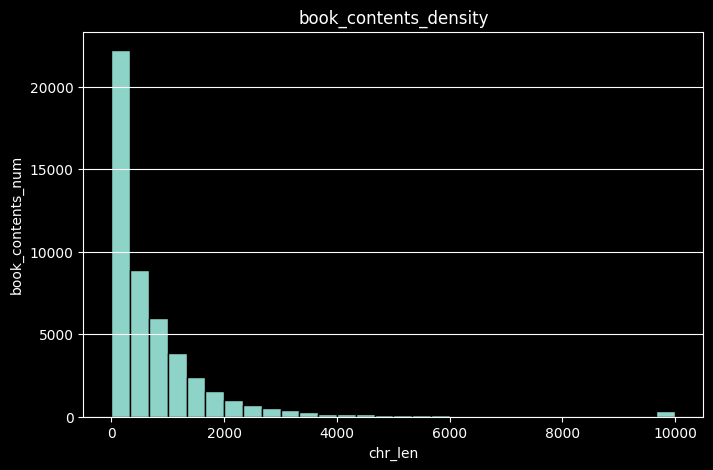

4436


In [ ]:
df["book_contents_char_count"] = df["목차"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["book_contents_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("book_contents_density")
plt.xlabel("chr_len")
plt.ylabel("book_contents_num")
plt.grid(axis="y")
plt.show()
print(df[df["book_contents_char_count"] > 2000].shape[0])